In [579]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import difflib
from pyspark.sql import SparkSession

## Objective of the analysis
1. Extract basic info with respect to vehicle registraions in the EU. (market share, fuel type, commonlty used brands etc.)
2. Identify the factors that effect the emission level.

In [580]:
#!pip3 install pyspark
#from pyspark.sql import SparkSession


 #### Data desciption
 
 
 'ID' - id
 'Country'-Country of registration
 'VFN'- Vehicle family identification
 'Mp'- Manufacturer pooling
 'Mh' - Manufacturer harmonised
 'Man' - Manufacturer name OEM declaration	
 'MMS'- Manufacturer name as in MS registry	
 'Tan',
 'T' - Type
 'Va' - Variant
 'Ve' - Version
 'Mk' - Make
 'Cn' - Commercial name	
 'Ct' - Category of the vehicle type approved	
 'Cr',
 'r' - Total new registrations	
 'm (kg)' - Mass
 'Mt',
 'Enedc (g/km)' - Specific CO2 Emissions under NEDC test	
 'Ewltp (g/km)' - Specific CO2 Emissions under WLTP test	
 'W (mm)' - Wheel Base	
 'At1 (mm)' - Axle width steering axle	 
 'At2 (mm)' - Axle width other axle	
 'Ft' - Fuel type	
 'Fm' - Fuel mode	
 'ec (cm3)'- Engine capacity	
 'ep (KW)' - Engine power
 'z (Wh/km)' - Electric energy consumption	
 'IT' - Innovative technology or group of innovative technologies	
 'Ernedc (g/km)',
 'Erwltp (g/km)',
 'De',
 'Vf',
 'Status',
 'year'- Registration year
 'Date of registration',
 'Fuel consumption ',
 'Electric range (km)'

In [798]:
#create spark session and read file and infer schema data types
spark = SparkSession.builder.appName("Vehicle_analysis").getOrCreate()
veh_data = spark.read.csv("data.csv", header=True, inferSchema=True)

In [583]:
#check data types
veh_data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- VFN: string (nullable = true)
 |-- Mp: string (nullable = true)
 |-- Mh: string (nullable = true)
 |-- Man: string (nullable = true)
 |-- MMS: string (nullable = true)
 |-- Tan: string (nullable = true)
 |-- T: string (nullable = true)
 |-- Va: string (nullable = true)
 |-- Ve: string (nullable = true)
 |-- Mk: string (nullable = true)
 |-- Cn: string (nullable = true)
 |-- Ct: string (nullable = true)
 |-- Cr: string (nullable = true)
 |-- r: integer (nullable = true)
 |-- m (kg): integer (nullable = true)
 |-- Mt: integer (nullable = true)
 |-- Enedc (g/km): integer (nullable = true)
 |-- Ewltp (g/km): integer (nullable = true)
 |-- W (mm): integer (nullable = true)
 |-- At1 (mm): string (nullable = true)
 |-- At2 (mm): string (nullable = true)
 |-- Ft: string (nullable = true)
 |-- Fm: string (nullable = true)
 |-- ec (cm3): integer (nullable = true)
 |-- ep (KW): integer (nullable = true)
 |-- z (Wh/

In [584]:
#Columns
#veh_data.columns

In [585]:
#print top 3 records
#veh_data.head(3)

In [586]:
#veh_data.show()

In [587]:
#veh_data.dtypes

In [588]:
#show one column
#veh_data.select(['Country','year']).show()

In [ ]:
# Find percentage of Null, None, and NaN per column
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.functions import round 
veh_data.select([ round( (count(when(isnan(c) | col(c).isNull(), c))) /veh_data.count(),3).alias(c) for c in veh_data.columns]).show()

Initial analysis on variables :

- ID column is not required for further analysis as it is a unique identifier.
- We can see that some columns have all of their data are missing, such as MMS, Ernedc (g/km), De, Vf. These columns we drop from our dataset.
- Also, we can exclude registration specific info like Man, MMS, TAN, T, Va, Ve, etc.
- What are important variables for us for the analysis.
    Country, Mp, Mk, m (kg), Ewltp (g/km), Ft, ec, ep, z, 

In [688]:
#missing_data_df = veh_data.select([ round( (count(when(isnan(c) | col(c).isNull(), c))) /veh_data.count(),3).alias(c) for c in veh_data.columns])

In [592]:
print((veh_data.count(), len(veh_data.columns)))

(9920120, 38)


## Variable Analysis


 Here we analyze few of the most important variables in our dataset.

### Country

In [593]:
veh_data.createOrReplaceTempView("TAB")
spark.sql("SELECT DISTINCT Country FROM TAB").show(50)


+-------+
|Country|
+-------+
|   null|
|     MT|
|     FR|
|     GR|
|     IE|
|     BE|
|     NO|
|     IS|
|     PL|
|     AT|
|     HR|
|     PT|
|     SK|
|     HU|
|     NL|
|     DE|
|     IT|
|     LV|
|     DK|
|     FI|
|     RO|
|     CZ|
|     SE|
|     CY|
|VW-SAIC|
|     EE|
|     SI|
|     LT|
|     BG|
|     LU|
|     ES|
+-------+



We can see there are some records with NULL values.  Also some records with country code 'VW-SAIC'. VW-SAIC is not a valid EU country code but it indicates the joint venture between SAIC Motor and VW Group. This seems like a mistake in data collection. Hence, we drop the records which has VW-SAIC as country code or NULL values.

Map country codes with country names

In [594]:
full_country_name = {'Belgium':'BE',
'Bulgaria':'BG',
'Czechia':'CZ',
'Denmark':'DK',
'Germany':'DE',
'Estonia':'EE',
'Ireland':'IE',
'Greece':'EL',
'Greece' : 'GR',
'Spain':'ES',
'France':'FR',
'Croatia':'HR',
'Italy':'IT',
'Iceland': 'IS',
'Cyprus':'CY',
'Latvia':'LV',
'Lithuania':'LT',
'Luxembourg':'LU',
'Hungary':'HU',
'Malta':'MT',
'Netherlands':'NL',
'Norway' : 'NO',
'Austria':'AT',
'Poland':'PL',
'Portugal':'PT',
'Romania':'RO',
'Slovenia':'SI',
'Slovakia':'SK',
'Finland':'FI',
'Sweden':'SE'}

full_country_name2 = dict((y, x) for x, y in full_country_name.items())


In [595]:
#Drop rows with VW-SAIC as country and null values
veh_data =  veh_data.where(veh_data['Country'] != 'VW-SAIC')
veh_data = veh_data.na.drop(subset=["Country"])


### Fuel type (Ft)

In [596]:
veh_data.createOrReplaceTempView("TAB")
spark.sql("SELECT DISTINCT Ft FROM TAB").show(50)

+---------------+
|             Ft|
+---------------+
|       ELECTRIC|
|PETROL/ELECTRIC|
|           null|
|DIESEL/ELECTRIC|
|         DIESEL|
|         PETROL|
|       HYDROGEN|
|            LPG|
|  NG-BIOMETHANE|
|             NG|
|        UNKNOWN|
|petrol/electric|
|            E85|
+---------------+



We have got null values, and  UNKNOWN fuel type that can be excluded from the dataset. And PETROL/ELECTRIC is also recorded as petrol/electric which needs to be corrected.

In [597]:
from pyspark.sql.functions import regexp_replace

veh_data =  veh_data.where(veh_data['Ft'] != 'UNKNOWN')
veh_data = veh_data.na.drop(subset=["Ft"])
veh_data = veh_data.withColumn('Ft', regexp_replace('Ft', 'petrol/electric', 'PETROL/ELECTRIC'))


### Manufaturer pool (Mp)

In [598]:
spark.sql("SELECT DISTINCT Mp FROM TAB").show(50)


+--------------------+
|                  Mp|
+--------------------+
|MAZDA-SUBARU-SUZU...|
|             HYUNDAI|
|                null|
|RENAULT-NISSAN-MI...|
|          STELLANTIS|
|                FORD|
|               TESLA|
|                 BMW|
|                 KIA|
|       MERCEDES-BENZ|
|             VW-SAIC|
+--------------------+



We can see null values in the dataset that can be dropped.

In [599]:
veh_data = veh_data.na.drop(subset=["Mp"])


### Emission data (Ewltp (g/km))

0.008% of data are missing for Ewltp (g/km). Since the missing values are a small amount we drop the missing valus.

In [600]:
veh_data = veh_data.na.drop(subset=["Ewltp (g/km)"])


### Make (Mk)

Closer to 0% data are missing for Mk. Since the missing values are a small amount we drop the missing valus.

In [601]:
veh_data = veh_data.na.drop(subset=["Mk"])


We want to check wether car manufacturer names are correctly updated in the data or not. First let's filter all the unique manufacturers.



In [602]:
#Check manufacture data for possible duplicates  

def get_manufacturer_names(df):
    #All unique manufactures after converting to upper case
    df.createOrReplaceTempView("TAB")
    all_manufactures = spark.sql("SELECT DISTINCT UPPER(Mk) FROM TAB")

    #Convert to pandas and sort in alphabetical order --> 111
    all_manufactures = all_manufactures.toPandas()
    all_manufactures.columns = ['Mk']
    all_manufactures = all_manufactures.sort_values(by='Mk')

    return all_manufactures

In [603]:
all_manufactures= get_manufacturer_names(veh_data)
all_manufactures

,Mk
76,ABARTH
15,AIWAYS
86,ALFA ROMEO
25,ALFA ROMEO
110,ALLIED
...,...
29,"VOLKSWAGEN, VW"
5,"VOLKSWAGEN,VW"
72,VOLKSWAGEN. VW
67,VW


In [604]:
#Let's check duplicates now. We can see most of the car manufacturer names are reported with slight deviations. To fix this issue we took the below steps.
# We asked chtGPT to generate a list of car manufacturers in the world known as "known_car_manufacturers" 
# Then found the difference between the list "known_car_manufacturers" and  "all_manufactures". (set(all_manufactures['Mk']).difference(set(known_car_manufacturers)))
# Then manually checked the difference and added the missing manufacturers to the "known_car_manufacturers" list.
# And found some other manufacturers that are incorrect hus needs to be droppped or updated manually on "known_car_manufacturers" list.
# Then for each car manufacturer on our dataset we are going to get the closest match picked from updated "known_car_manufacturers" list.
# The others are assigned a value as Not Specified.



In [605]:
#Generated by ChatGPT updated by us adding missing manufacturers
known_car_manufacturers = [
    "ALFA ROMEO",
    "ASTON MARTIN",
    "AUDI",
    "BENTLEY",
    "BMW",
    "BUGATTI",
    "BUICK",
    "CADILLAC",
    "CHEVROLET",
    "CHRYSLER",
    "CITROEN",
    "DACIA",
    "DAIHATSU",
    "DODGE",
    "FERRARI",
    "FIAT",
    "FORD",
    "GMC",
    "HONDA",
    "HYUNDAI",
    "INFINITI",
    "JAGUAR",
    "JEEP",
    "KIA",
    "KOENIGSEGG",
    "LAMBORGHINI",
    "LANCIA",
    "LAND ROVER",
    "LEXUS",
    "LINCOLN",
    "LOTUS",
    "MASERATI",
    "MAZDA",
    "MCLAREN",
    "MERCEDES-BENZ",
    "MINI",
    "MITSUBISHI",
    "NISSAN",
    "PAGANI",
    "PEUGEOT",
    "PORSCHE",
    "RAM",
    "RENAULT",
    "ROLLS-ROYCE",
    "SAAB",
    "SCION",
    "SEAT",
    "ŠKODA",
    "SMART",
    "SUBARU",
    "SUZUKI",
    "TATA MOTORS",
    "TESLA",
    "TOYOTA",
    "VAUXHALL",
    "VOLKSWAGEN",
    "VOLVO",  #add missing manufacturer names found on our data
    'ABARTH',
    'AIWAYS',
    'ALPINE',
    'ALLIED',
    'API CZ',
    'BUSCONCEPT',
    'CUPRA',
    'DANGEL',
    'DETHLEFFS',
    'DREAMER',
    'DS',
    'E.GO',
    'FCA ITALY SPA',
    'FORCE MOTORS',
    'FORD-CNG-TECKNIK',
    'FORSTER',
    'INDUS AUTOMOBILE',
    'JAC',
    'KLASSEN',
    'LADA',
    'LEVC',
    'OPEL',
    'PÖSSL',
    'PSA AUTOMOBILES',
    'ROLLER TEAM',
    'SHAUSSON',
    'SKYWELL',
    'MG',
    'LYNK & CO',
    'SPRINTCAR',
    'TRIPOD',
    'SIN MARCA',
    'KEAT' ]
    

In [606]:
#Drop incorrectly reported manufacturer names which we cannot determine
veh_data = veh_data.filter(veh_data.Mk != 'ALPIN')


#Replace incorrect manufacturer names or which needs to be updated to a common name for clarity
replace_dict = {
"DS AUTOMOBILES":"DS",
"VW":"VOLKSWAGEN",
"SOCIETE DES AUTOMOBILES ALPINE(SAA)":"ALPINE",
"FORSTER":"SUBARU",
"DAIMLER AG":"MERCEDES-BENZ",
"QUATTRO":"AUDI",
"INDUSAUTO":"INDUS AUTOMOBILE",
"MERCEDES":"MERCEDES-BENZ",
"MERCEDES AMG":"MERCEDES-BENZ",
"MERCEDES-AMG" :"MERCEDES-BENZ"
}


def replace_str(dict, df):
    for d in dict.items():
        df = df.withColumn('Mk', when(col("Mk") == d[0],d[1]).otherwise(df.Mk))
        print(d)
    return df 

veh_data = replace_str(replace_dict, veh_data)   

#regenerate manufacturer data with updates
all_manufactures= get_manufacturer_names(veh_data)


('DS AUTOMOBILES', 'DS')
('VW', 'VOLKSWAGEN')
('SOCIETE DES AUTOMOBILES ALPINE(SAA)', 'ALPINE')
('FORSTER', 'SUBARU')
('DAIMLER AG', 'MERCEDES-BENZ')
('QUATTRO', 'AUDI')
('INDUSAUTO', 'INDUS AUTOMOBILE')
('MERCEDES', 'MERCEDES-BENZ')
('MERCEDES AMG', 'MERCEDES-BENZ')
('MERCEDES-AMG', 'MERCEDES-BENZ')


In [607]:
#%%script false --no-raise-error
#Check accuracy of mapping and update
from pyspark.sql.functions import when
import re

all_macthes=[]


for manufature in all_manufactures['Mk']:
    
    #close matches
    matches = difflib.get_close_matches(manufature, known_car_manufacturers, n=10, cutoff=0.8) 
    print(manufature," ---> ",matches)
    #if no matches found
    if  not matches:
        print("No direct mactch found, retry.. \n")
        #count number of words
        if len(manufature.split(' ')) > 1:
            #count characters execept spaces
            #if number of words >1 and characters >3 then consider first word as the manufacturer name
            if len(manufature.replace(" ", "")) > 3:
                
                #Check fist word for a possible match
                new_manufature_str = manufature.split(' ')[0]

            #if number of words >1 but character count < 3 then
            else:
                new_manufature_str = manufature.replace(" ", "")
            
            matches = difflib.get_close_matches(new_manufature_str, known_car_manufacturers, n=10, cutoff=0.8) 
            print(manufature," ---> ",matches)


ABARTH  --->  ['ABARTH']
AIWAYS  --->  ['AIWAYS']
ALFA  ROMEO  --->  ['ALFA ROMEO']
ALFA ROMEO  --->  ['ALFA ROMEO']
ALLIED  --->  ['ALLIED']
ALLIED VEHICLES LTD  --->  []
No direct mactch found, retry.. 

ALLIED VEHICLES LTD  --->  ['ALLIED']
ALPINE  --->  ['ALPINE']
API CZ  --->  ['API CZ']
AUDI  --->  ['AUDI']
B M W  --->  []
No direct mactch found, retry.. 

B M W  --->  ['BMW']
BMW  --->  ['BMW']
BMW I  --->  []
No direct mactch found, retry.. 

BMW I  --->  ['BMW']
BUGATTI  --->  ['BUGATTI']
BUSCONCEPT  --->  ['BUSCONCEPT']
CITROEN  --->  ['CITROEN']
CITROEN / DS  --->  []
No direct mactch found, retry.. 

CITROEN / DS  --->  ['CITROEN']
CUPRA  --->  ['CUPRA']
DACIA  --->  ['DACIA']
DACIA - ROMTURING  --->  []
No direct mactch found, retry.. 

DACIA - ROMTURING  --->  ['DACIA']
DANGEL  --->  ['DANGEL']
DETHLEFFS  --->  ['DETHLEFFS']
DODGE  --->  ['DODGE']
DREAMER  --->  ['DREAMER']
DS  --->  ['DS']
E.GO  --->  ['E.GO']
FCA ITALY SPA  --->  ['FCA ITALY SPA']
FIAT  --->  ['FIAT']
F

In [609]:
#%%script false --no-raise-error
#Update the records
from pyspark.sql.functions import when
import re

all_macthes=[]


for manufature in all_manufactures['Mk']:
    #close matches
    matches = difflib.get_close_matches(manufature, known_car_manufacturers, n=10, cutoff=0.8) 
    if  len(matches)==1:
        veh_data = veh_data.withColumn('Mk', when(col("Mk") == manufature, matches[0]).otherwise(veh_data.Mk))

### Null value handling for other variales
- For Country, emmision data (Ewltp (g/km)), make (mk), fuel type (ft) we drop any records with null values.
- For EC, EP, and M we decided to impute the missing values.But before that we analyze EC, EP, and M with respect to Country, emmision data (Ewltp (g/km)), make (mk), and fuel type (ft).

So what are the prominent findings..
-  Country ---> We can see that Norway (NO) has about 65.5%  missing values  with respect to  ec (cm3). 
-  Mk ---> With respect to car brands (make/Mk) there exists multiple brands that has missing values for all the records wrt  ec (cm3). Whereas 4 brands have missing values wrt to ep (KW) greater than 50%. 
-  Ft ---> Majority of the values (>99%) are missing wrt ELECTRIC and HYDROGEN types concerning the ec (cm3) variable. 
-  For ELECTRIC/ HYDROGEN based vehicles engine capacity (volume of fuel) is not a relavent masure. Hence, There is no point of imputing ec (cm3) with respect to these car types. 
-  Since Norway has a high % of electric cars, the high % missing values wrt the ec (cm3) variable is understandable.

So what's the paln for imputation. 
 - Since for electric cars have no values for  ec (cm3) there is no need to impute it. But we have to make a note to exclude any electric or hydrogen cars from analysis done on ec (cm3).
 - For the rest of the fuel types (Ft) we impute ec (cm3) using mean of the particular Ft.
 - For ep (KW) we impute ec (cm3) using the mean of the particular Ft.

In [617]:
# For 'ec (cm3)','ep (KW)', and 'm (kg)' columns we plan to impute the missing values. However, before that we would like to see whether any missing data are random or systematic.  
# Hence we compute missing data % for each of the above three variables grouped by "Country", "Mk" and "Mp" respectively. 

from pyspark.sql import Row ,functions as f
group_columns= ['Country',  'Ft']
count_columns=['ec (cm3)','ep (KW)','m (kg)']

for g in group_columns:
    for c in count_columns:
        print("Group by column: ", g, " Null count column : ", c)
        print(veh_data.groupBy(col(g)).agg((f.sum(col(c).isNull().cast("integer"))/count("*")).alias("Null_perct")  ).orderBy(col("Null_perct").desc()).show(10))

Group by column:  Country  Null count column :  ec (cm3)
+-------+-------------------+
|Country|         Null_perct|
+-------+-------------------+
|     NO| 0.6558762926303222|
|     IS| 0.2846502867905145|
|     SE| 0.2186241320516939|
|     NL|0.19344614957905312|
|     DE|0.14189564025584128|
|     AT|0.14005609382967873|
|     DK|0.13413643591767627|
|     LU|0.11680296250578615|
|     FI|0.10731959354727597|
|     FR|0.09575890255170943|
+-------+-------------------+
only showing top 10 rows

None
Group by column:  Country  Null count column :  ep (KW)
+-------+--------------------+
|Country|          Null_perct|
+-------+--------------------+
|     BE| 0.09421608457347679|
|     FI|0.057707101440955276|
|     RO| 0.05320623189014404|
|     EE|0.018670581219321986|
|     DE|0.013150208850019579|
|     PL|0.012126856917634031|
|     ES|0.004266932798354328|
|     MT|0.001654601861427094|
|     NO|1.861516044342596E-4|
|     NL|1.386807737710684...|
+-------+--------------------+
on

In [691]:
#ft_list = ['PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE', 'PETROL/ELECTRIC','DIESEL/ELECTRIC', 'ELECTRIC', 'HYDROGEN']
#for ft in ft_list:
#veh_data.groupBy( col('Ft')).agg(   (f.sum(col('z (Wh/km')).isNull().cast("integer"))  / count("*") ).alias("Null_perct"))

#print(veh_data.groupBy(col('Ft')).agg((f.sum(col('z (Wh/km').isNull().cast("integer"))/count("*")).alias("Null_perct")  ).orderBy(col("Null_perct").desc()).show(10))

In [616]:
#Get unique fuel types
veh_data.createOrReplaceTempView("TAB")
ft_types= spark.sql("SELECT DISTINCT UPPER(Ft) FROM TAB")
ft_types = ft_types.toPandas()
ft_types.columns = ['Ft']
ft_types = ft_types['Ft']

In [622]:
from pyspark.sql.functions import mean

rem_ft_list= ['ELECTRIC', 'HYDROGEN']

#Data imputation
for ft in ft_types:
    #exclude ELECTRIC and HYDROGEN cars

    if ft not in rem_ft_list:
        #select fuel based mean values
        ft_data = veh_data.filter(veh_data.Ft == ft)
        ec_mean_val =    ft_data.select(mean("ec (cm3)")).collect()
        ep_mean_val =    ft_data.select(mean("ep (KW)")).collect()
        m_mean_val  =    ft_data.select(mean("m (kg)")).collect()

        #update na values
        veh_data = veh_data.na.fill(ec_mean_val[0][0],subset=['ec (cm3)'])
        veh_data = veh_data.na.fill(ep_mean_val[0][0],subset=['ep (KW)'])
        veh_data = veh_data.na.fill(m_mean_val[0][0],subset=['m (kg)'])
    

In [ ]:
#veh_data.select([ round( (count(when(isnan(c) | col(c).isNull(), c))) /veh_data.count(),3).alias(c) for c in veh_data.columns]).show()

## EDA

[Text(0.5, 0, 'New Registrations %'), Text(0, 0.5, 'Country')]

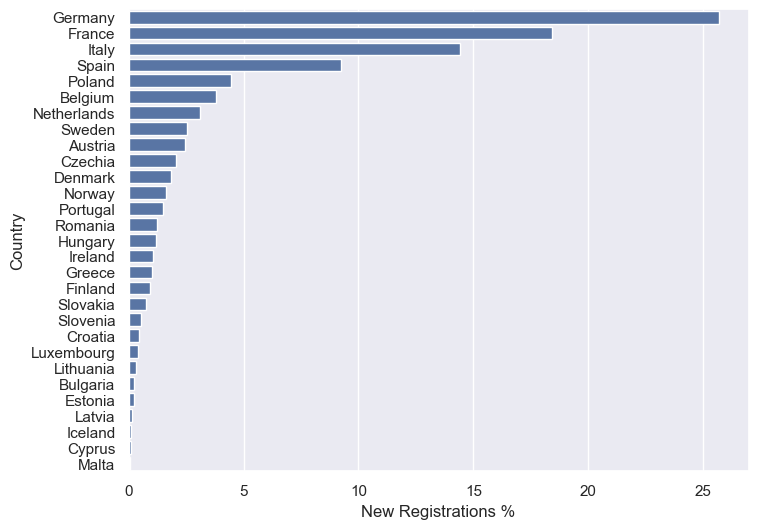

In [623]:
#Q. Show a contrywise total new car registrations as a percentage.
import pyspark.sql.functions as f
from pyspark.sql.window import Window

#groupby country, compute percentages and assign a column name
country_df = veh_data.groupBy("Country").agg( ((f.count('Country')/veh_data.count())*100).alias("perc_by_country") )

#order by percentage values desc
country_df= country_df.orderBy(country_df.perc_by_country.desc())


#Snice we have a small dataframe now I convert it to pandas df
country_df = country_df.toPandas()

#Replace country codes with full country names
country_df = country_df.replace({"Country": full_country_name2})


#Vizualize percentage of new vehicle registrations in 2019 by country
sns.set(rc = {'figure.figsize':(8,6)})
ax = sns.barplot(data=country_df, x='perc_by_country', y='Country', orient = 'h', color='b')

ax.set(xlabel='New Registrations %', ylabel='Country')



In [624]:
country_df

,Country,perc_by_country
0,Germany,25.681995
1,France,18.423263
2,Italy,14.407172
3,Spain,9.258359
4,Poland,4.465310
5,Belgium,3.811171
6,Netherlands,3.097141
7,Sweden,2.543707
8,Austria,2.465200
9,Czechia,2.066936


[Text(0.5, 0, 'Fuel Type %'), Text(0, 0.5, 'Fuel Type')]

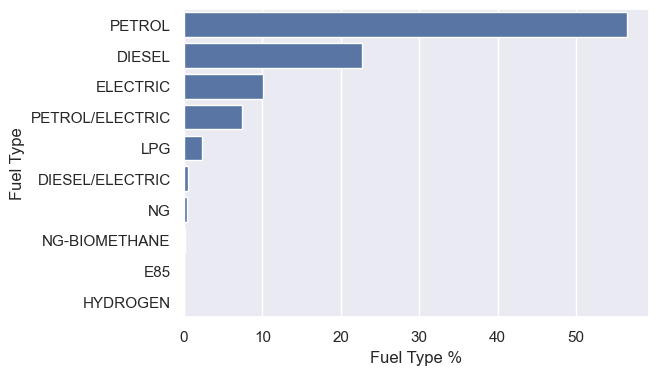

In [625]:
#Q. Show the fuel type percentages for car registrations in 2019.

veh_data = veh_data.withColumn('Ft', when(col("Ft") == "petrol/electric","PETROL/ELECTRIC").otherwise(veh_data.Ft))


ft_df = veh_data.groupBy("Ft").agg( ((f.count("Ft")/veh_data.count())*100).alias("perc_by_fueltype") )
ft_df= ft_df.orderBy(ft_df.perc_by_fueltype.desc())
ft_df = ft_df.toPandas() 
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.barplot(data=ft_df, x='perc_by_fueltype', y='Ft', orient = 'h', color='b')
ax.set(xlabel='Fuel Type %', ylabel='Fuel Type')


In [628]:
#What is the most common fuel type for cars registered in 2019 by each country.

from pyspark.sql import Window
tmp_df = veh_data.groupBy(["Country","Ft"]).count()
w = Window.partitionBy('Country')
ft_cnt_df = tmp_df.withColumn('MostCommonFuelType', f.max('count').over(w))\
    .where(f.col('count') == f.col('MostCommonFuelType')).drop(col("MostCommonFuelType"))

ft_cnt_df = ft_cnt_df.toPandas()

In [629]:
ft_cnt_df = ft_cnt_df.replace({"Country": full_country_name2})
ft_cnt_df

,Country,Ft,count
0,Austria,PETROL,119421
1,Belgium,PETROL,206296
2,Bulgaria,PETROL,15054
3,Cyprus,PETROL,8098
4,Czechia,PETROL,138464
5,Germany,PETROL,1226622
6,Denmark,PETROL,94783
7,Estonia,PETROL,15622
8,Spain,PETROL,571653
9,Finland,PETROL,54351


In [630]:
#Analyzing Norway results
norway_df = tmp_df.filter(tmp_df.Country == "NO")
norway_df = norway_df.toPandas()
norway_df = norway_df[['Ft','count']]
norway_df['perc'] = norway_df['count']/norway_df['count'].sum()
norway_df

,Ft,count,perc
0,DIESEL,6409,0.041140
1,DIESEL/ELECTRIC,1572,0.010091
2,ELECTRIC,102141,0.655645
3,PETROL,17060,0.109508
4,PETROL/ELECTRIC,28569,0.183385
5,HYDROGEN,36,0.000231


In [634]:
#Comparison with rest of the Nordic
nordic_countries = ["NO", "DK", "IS", "FI", "SE"]
nordic_df = tmp_df.filter(tmp_df.Country.isin(nordic_countries))


In [635]:
nord_ft_cnt_df = nordic_df.toPandas()


In [636]:
nord_ft_cnt_df['perc']='NA'

for country in nord_ft_cnt_df['Country']:
    perc = nord_ft_cnt_df[nord_ft_cnt_df['Country']==country]['count']/nord_ft_cnt_df[nord_ft_cnt_df['Country']==country]['count'].sum()
    nord_ft_cnt_df.loc[nord_ft_cnt_df['Country']==country, 'perc'] = perc
nord_ft_cnt_df = nord_ft_cnt_df.replace({"Country": full_country_name2})


(0.0, 1.0)

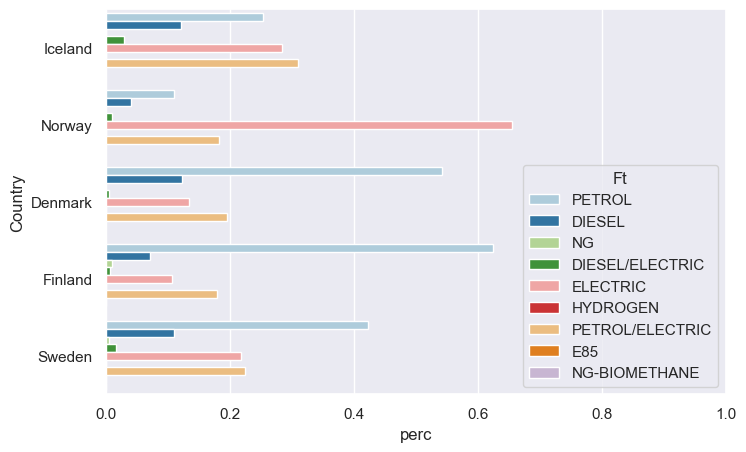

In [637]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.barplot(data=nord_ft_cnt_df, x='perc', y='Country', hue='Ft', orient = 'h',  palette = "Paired", width=0.9)
plt.xlim(0,1)

In [ ]:
#top 10 car brands in EU for 2019
mk_df = veh_data.groupBy(["Mk"]).agg(   ((f.count("Mk")/veh_data.count()) *100).alias("Perc_registrations"))
mk_df = mk_df.orderBy(mk_df.Perc_registrations.desc())
mk_df.show(10)


In [ ]:
# filter vehicle registrations in Sweden in 2019

sweden_df = veh_data.filter(veh_data.Country == "SE")


In [ ]:
#top 10 car brands in sweden for 2019
se_mk_df = sweden_df.groupBy(["Mk"]).agg(   ((f.count("Mk")/sweden_df.count()) *100).alias("Num_registrations"))
se_mk_df = se_mk_df.orderBy(se_mk_df.Num_registrations.desc())
se_mk_df.show(10)


In [ ]:
# Fuel types in Sweden
se_ft_df = sweden_df.groupBy(["ft"]).count()
se_ft_df.show()

### Vizualization

Code from : https://github.com/roshankoirala/pySpark_tutorial/blob/master/Data_visualization_in_pySpark%20.ipynb

In [639]:
def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    plt.figure(figsize=(5,5))
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()


    
def boxplot(df, col, group_by, samp_size=10000): 
    
    '''
    This function makes a box plot for a Spark dataframe df 
    grouping them by a column name called group_by and their
    aggrigate on another column called col. 
    '''
    
    # Selecting sample for the large dataset 
    # For samll data sampling is not done. For the large data 
    # sample size is the specified number. 
    
    true_samp_size = min(samp_size/df.count(), 1.0)
    pd_df = df.sample(False, true_samp_size).toPandas()
    
    # Making plot 
    pd_df.boxplot(col, by=group_by, figsize=(25, 7))
    plt.ylabel(col)
    plt.title(None)
    plt.show()

### Emission

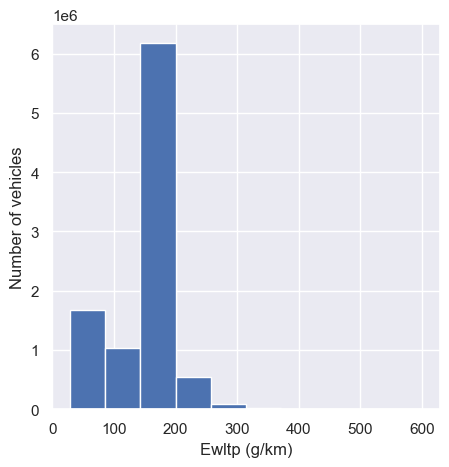

In [640]:
#Q Vizualize emmision data

histogram(veh_data, 'Ewltp (g/km)', bins=10, yname='Number of vehicles')

In [641]:
# What is the avg emmision for vehicles registered in the EU for 2019 based on Ewltp (g/km)
from pyspark.sql.functions import avg

veh_data.select(avg('Ewltp (g/km)')).collect()

[Row(avg(Ewltp (g/km))=114.72317801274629)]

In [ ]:
#boxplot(veh_data, 'Ewltp (g/km)', 'Country',100000)


Text(0.5, 0, 'Fuel Type')

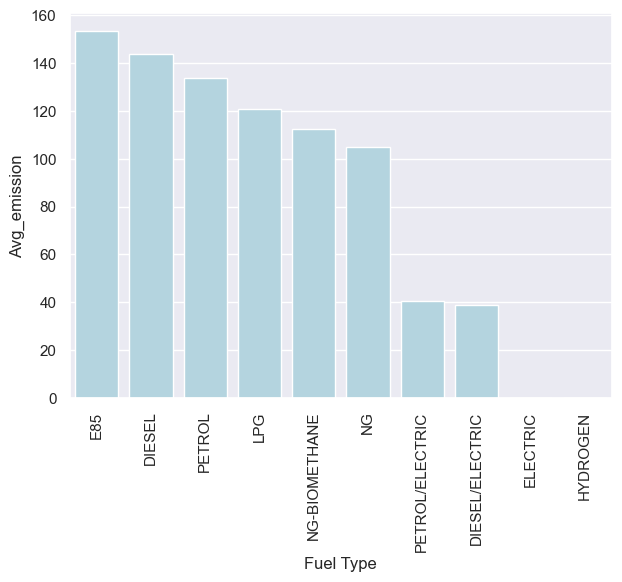

In [642]:
#Q. Compute average emission by fule type
avg_emm_ft = veh_data.groupBy(["Ft"]).agg(f.avg('Ewltp (g/km)').alias("Avg_emission"))
avg_emm_ft = avg_emm_ft.orderBy(avg_emm_ft.Avg_emission.desc())
avg_emm_ft = avg_emm_ft.toPandas()


#Vizualization
sns.set(rc = {'figure.figsize':(7,5)})
sns.barplot(data=avg_emm_ft, x='Ft', y='Avg_emission', color='lightblue')
ax=plt.xticks(rotation=90)
plt.xlabel('Fuel Type')

#### Average emmision for fossil fuel vs other

In [795]:
ft_high_emm = ['PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE']
avg_emm_ft[avg_emm_ft['Ft'].isin(ft_high_emm)]['Avg_emission'].mean()

128.15602759522298

In [796]:
ft_low_emm = [ 'PETROL/ELECTRIC','DIESEL/ELECTRIC', 'ELECTRIC', 'HYDROGEN']
avg_emm_ft[avg_emm_ft['Ft'].isin(ft_low_emm)]['Avg_emission'].mean()

19.873026908681172

In [643]:
#Q. Compute average emmision by country
country_emm = veh_data.groupBy(["Country"]).agg(f.avg("Ewltp (g/km)").alias("Avg_emission"))


country_emm = country_emm.orderBy(country_emm.Avg_emission.desc())
country_emm = country_emm.toPandas()
country_emm = country_emm.replace({"Country":full_country_name2})


In [644]:
mean_emm = veh_data.select(avg('Ewltp (g/km)')).collect()[0][0]

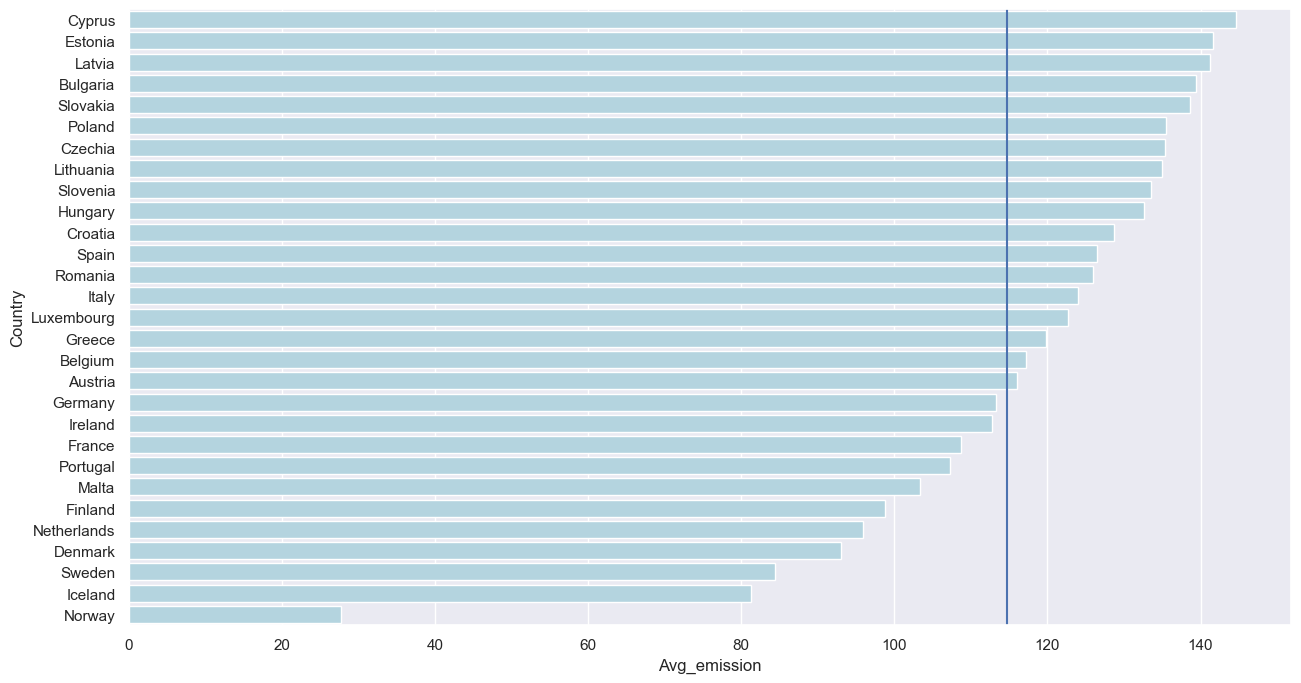

In [645]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(data=country_emm, x='Avg_emission', y='Country', color='lightblue')
plt.axvline(mean_emm, 0,50)


In [646]:
#Q Count number of new reistrations manufacturer pool wise.
man_pool_reg_df = veh_data.groupBy(["Mp"]).agg(f.count("Mp").alias("num_registrations"))
man_pool_reg_df= man_pool_reg_df.orderBy(man_pool_reg_df.num_registrations.desc())

man_pool_reg_df = man_pool_reg_df.toPandas()

man_pool_reg_df

,Mp,num_registrations
0,VW-SAIC,2472760
1,STELLANTIS,2131818
2,RENAULT-NISSAN-MITSUBISHI,1297214
3,MAZDA-SUBARU-SUZUKI-TOYOTA,946912
4,BMW,656979
5,MERCEDES-BENZ,533768
6,HYUNDAI,438643
7,FORD,423934
8,KIA,411417
9,TESLA,232231


In [647]:
#Q2. Compute average emission by manufacture pool  based on Ewltp (g/km)
mp_emission = veh_data.groupBy("Mp").agg(f.avg("Ewltp (g/km)").alias("Avg_emission"))
mp_emission = mp_emission.orderBy(mp_emission.Avg_emission.desc())
mp_emission = mp_emission.toPandas()

mp_emission = mp_emission.fillna('Not Specified')

In [648]:
mp_emission

,Mp,Avg_emission
0,FORD,120.874981
1,VW-SAIC,119.088128
2,MAZDA-SUBARU-SUZUKI-TOYOTA,118.412342
3,BMW,117.310669
4,STELLANTIS,116.107806
5,MERCEDES-BENZ,116.060152
6,RENAULT-NISSAN-MITSUBISHI,110.783834
7,HYUNDAI,108.144954
8,KIA,106.871809
9,TESLA,67.209145


Text(0, 0.5, 'Manufacturer pool (Mp)')

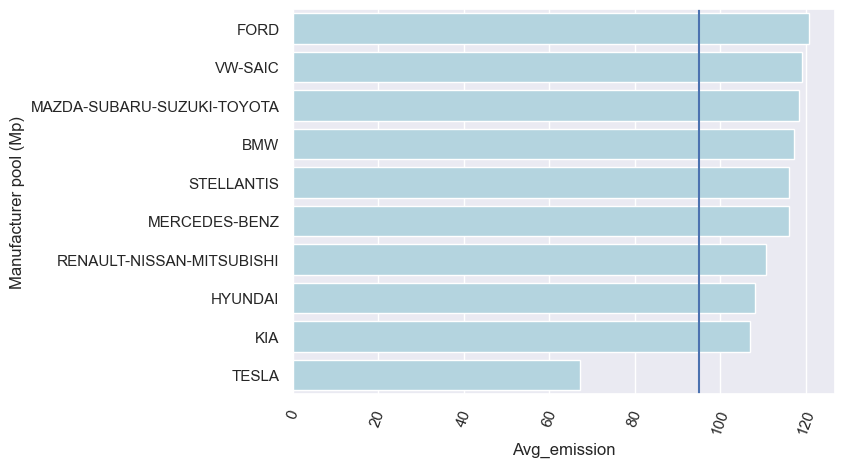

In [649]:
sns.set(rc = {'figure.figsize':(7,5)})
sns.barplot(data=mp_emission, y='Mp', x='Avg_emission', color='lightblue')
plt.axvline(95, 0,50)
ax=plt.xticks(rotation=70)
plt.ylabel("Manufacturer pool (Mp)")

## Bivariate analysis

### Correlation

Analyze the correlation between emission level and the engine cpacity, engine power, and mass of the vehicle with respect to different fuel type.


In [678]:
sam_df = veh_data.select('Ft', 'ec (cm3)','ep (KW)','Ewltp (g/km)','m (kg)')

In [680]:
#ft_list = ['PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE', 'PETROL/ELECTRIC','DIESEL/ELECTRIC', 'ELECTRIC', 'HYDROGEN']
ft_list_fossil = ['PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE']
ft_list_hybrid = [ 'PETROL/ELECTRIC','DIESEL/ELECTRIC']

fossil_df = veh_data.filter(veh_data.Ft.isin(ft_list_fossil))
hybrid_df = veh_data.filter(veh_data.Ft.isin(ft_list_hybrid))


In [681]:
print(" Fossil ->  Correltion between Ewltp (g/km) vs ec (cm3)", fossil_df.stat.corr('Ewltp (g/km)','ec (cm3)')) 
print(" Hybrid -> Correltion between Ewltp (g/km) vs ec (cm3)", hybrid_df.stat.corr('Ewltp (g/km)','ec (cm3)')) 

 Fossil ->  Correltion between Ewltp (g/km) vs ec (cm3) 0.6189812099492125
 Hybrid -> Correltion between Ewltp (g/km) vs ec (cm3) 0.058003796275521685


In [682]:
print(" Fossil ->  Correltion between Ewltp (g/km) vs ep (KW)", fossil_df.stat.corr('Ewltp (g/km)','ep (KW)')) 
print(" Hybrid -> Correltion between Ewltp (g/km) vs ep (KW)", hybrid_df.stat.corr('Ewltp (g/km)','ep (KW)')) 

 Fossil ->  Correltion between Ewltp (g/km) vs ep (KW) 0.7850381672748377
 Hybrid -> Correltion between Ewltp (g/km) vs ep (KW) 0.16696801965146182


In [683]:
print(" Fossil ->  Correltion between Ewltp (g/km) vs m (kg)", fossil_df.stat.corr('Ewltp (g/km)','m (kg)')) 
print(" Hybrid -> Correltion between Ewltp (g/km) vs m (kg)", hybrid_df.stat.corr('Ewltp (g/km)','m (kg)')) 

 Fossil ->  Correltion between Ewltp (g/km) vs m (kg) 0.7278997085488735
 Hybrid -> Correltion between Ewltp (g/km) vs m (kg) 0.16414617957589725


In [654]:
#Count fuel type wise registrations
ft_count = veh_data.groupBy(["Ft"]).count()
ft_count = ft_count.toPandas()
ft_count

,Ft,count
0,ELECTRIC,963038
1,PETROL/ELECTRIC,705797
2,DIESEL/ELECTRIC,50658
3,DIESEL,2168877
4,PETROL,5390656
5,HYDROGEN,439
6,LPG,213591
7,NG-BIOMETHANE,7526
8,NG,39068
9,E85,6026


In [660]:
#stratified sample
sampled_data_emm = veh_data.sampleBy("Ft", fractions={'PETROL':0.001,'DIESEL': 0.001, 'PETROL/ELECTRIC': 0.02, 'DIESEL/ELECTRIC':0.02, 'LPG':0.5, 'NG-BIOMETHANE':0.5, 'NG':0.5, 'E85':0.5}, seed=0).toPandas()

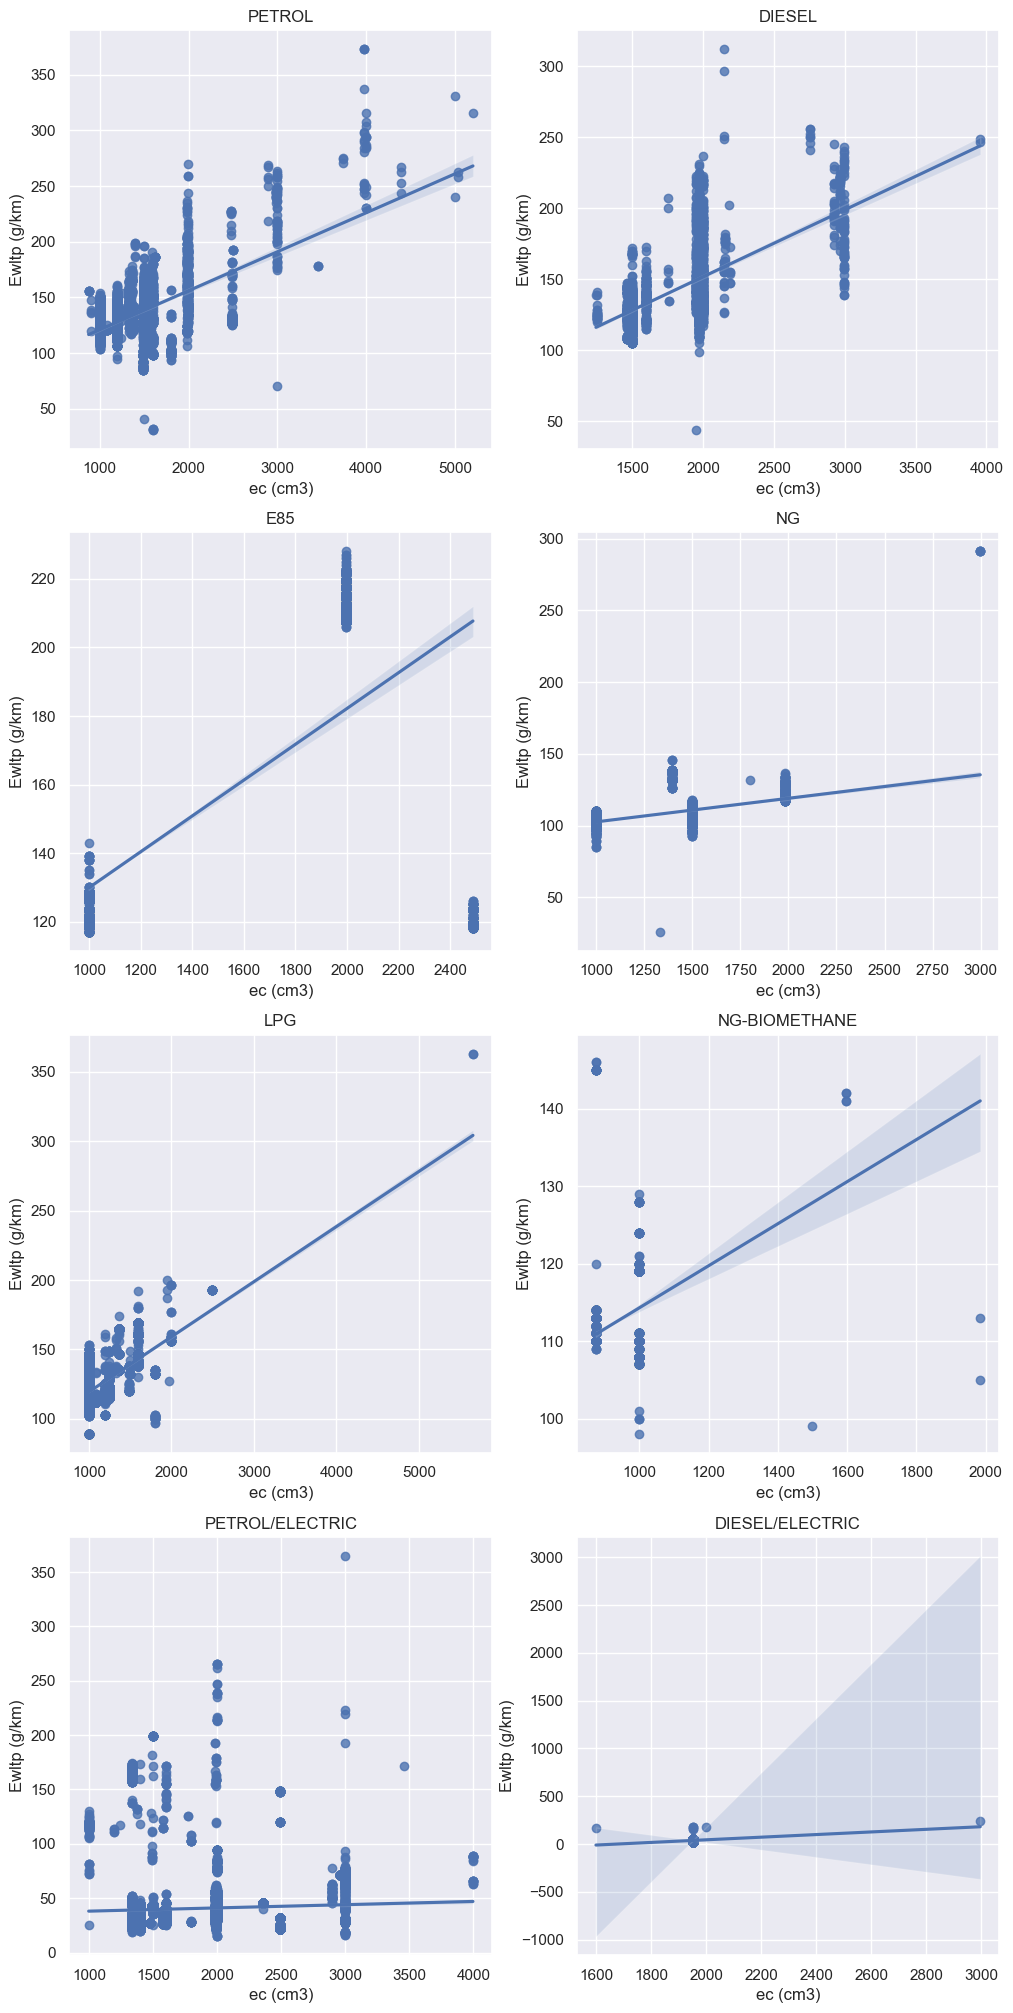

In [663]:
ft_list = ['PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE', 'PETROL/ELECTRIC','DIESEL/ELECTRIC']


sns.set(rc = {'figure.figsize':(12,25)})

fig, axes = plt.subplots(4, 2)

for f, ax in zip(ft_list, axes.ravel()):

    dt = sampled_data_emm[sampled_data_emm["Ft"] == f]
    sns.regplot(data=dt, x='ec (cm3)', y='Ewltp (g/km)', ax=ax).set_title(f)


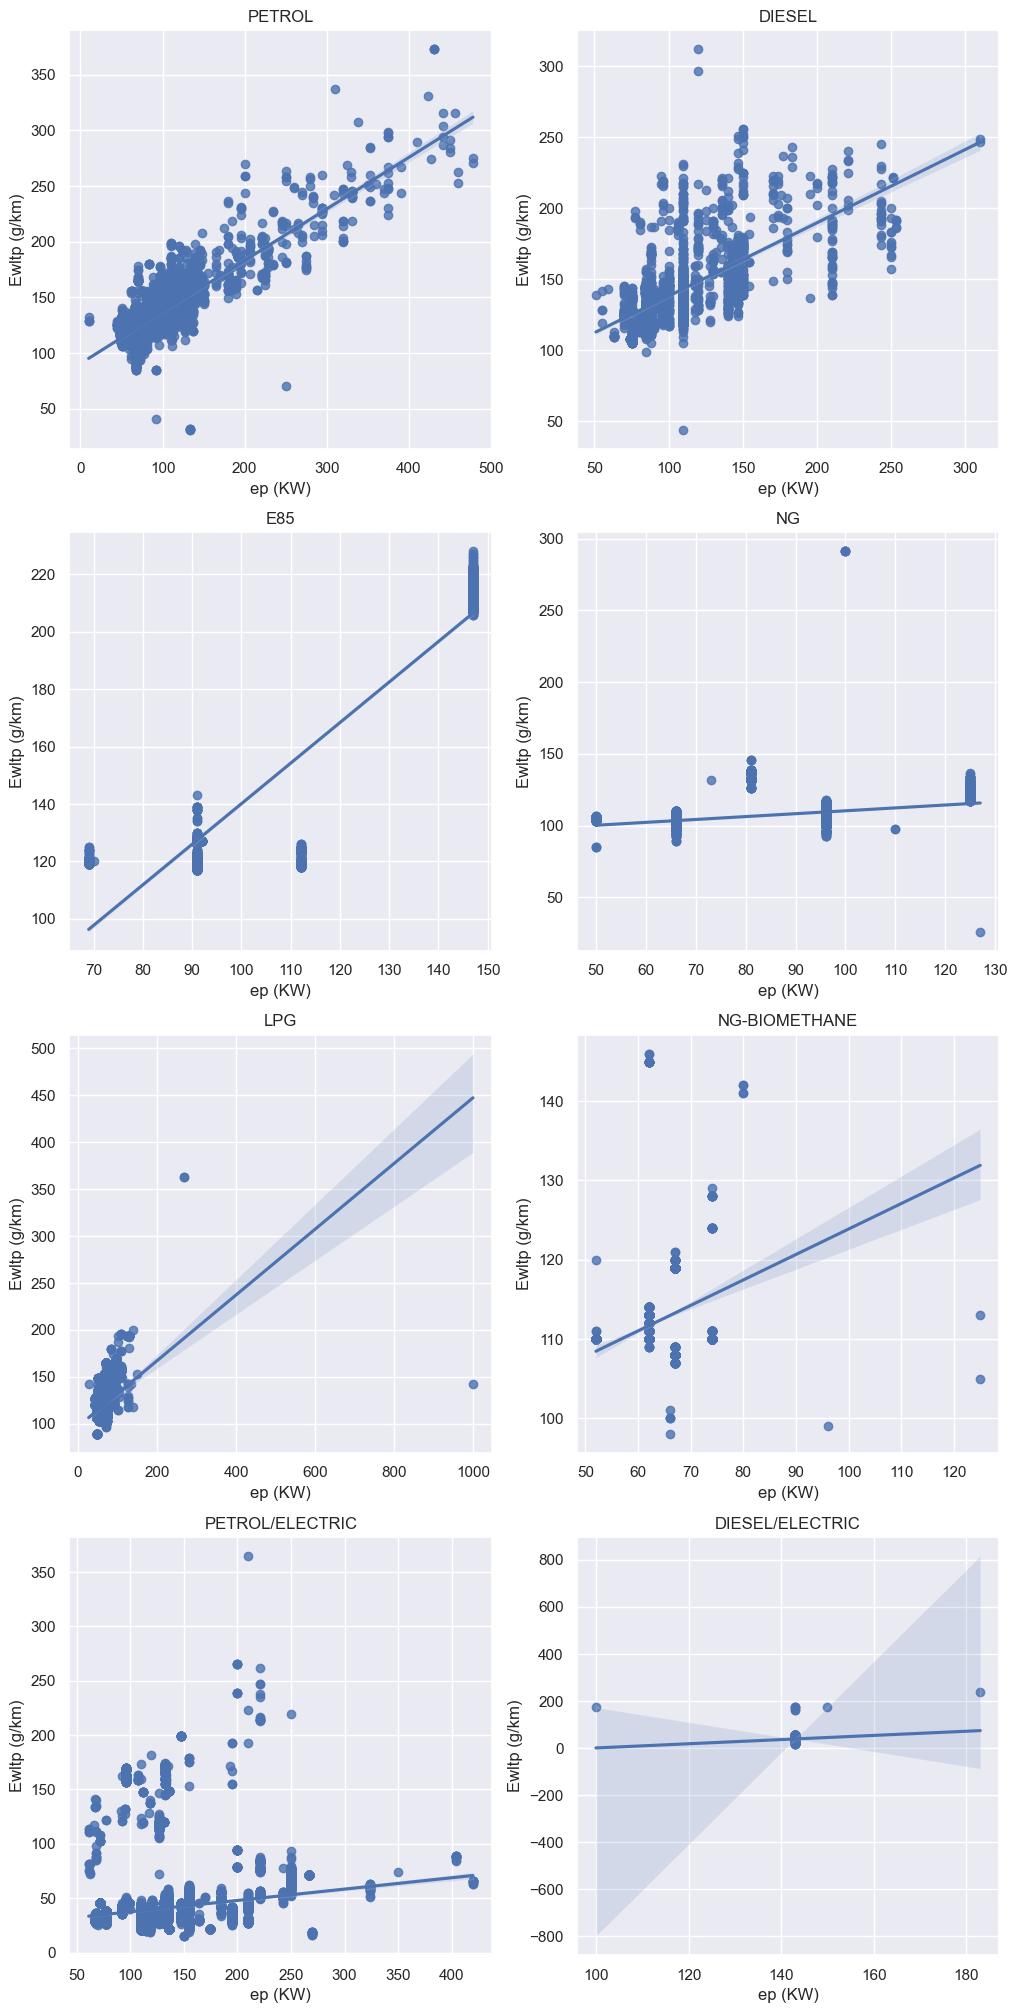

In [664]:
sns.set(rc = {'figure.figsize':(12,25)})

fig, axes = plt.subplots(4, 2)

for f, ax in zip(ft_list, axes.ravel()):

    dt = sampled_data_emm[sampled_data_emm["Ft"] == f]
    sns.regplot(data=dt, x='ep (KW)', y='Ewltp (g/km)', ax=ax).set_title(f)

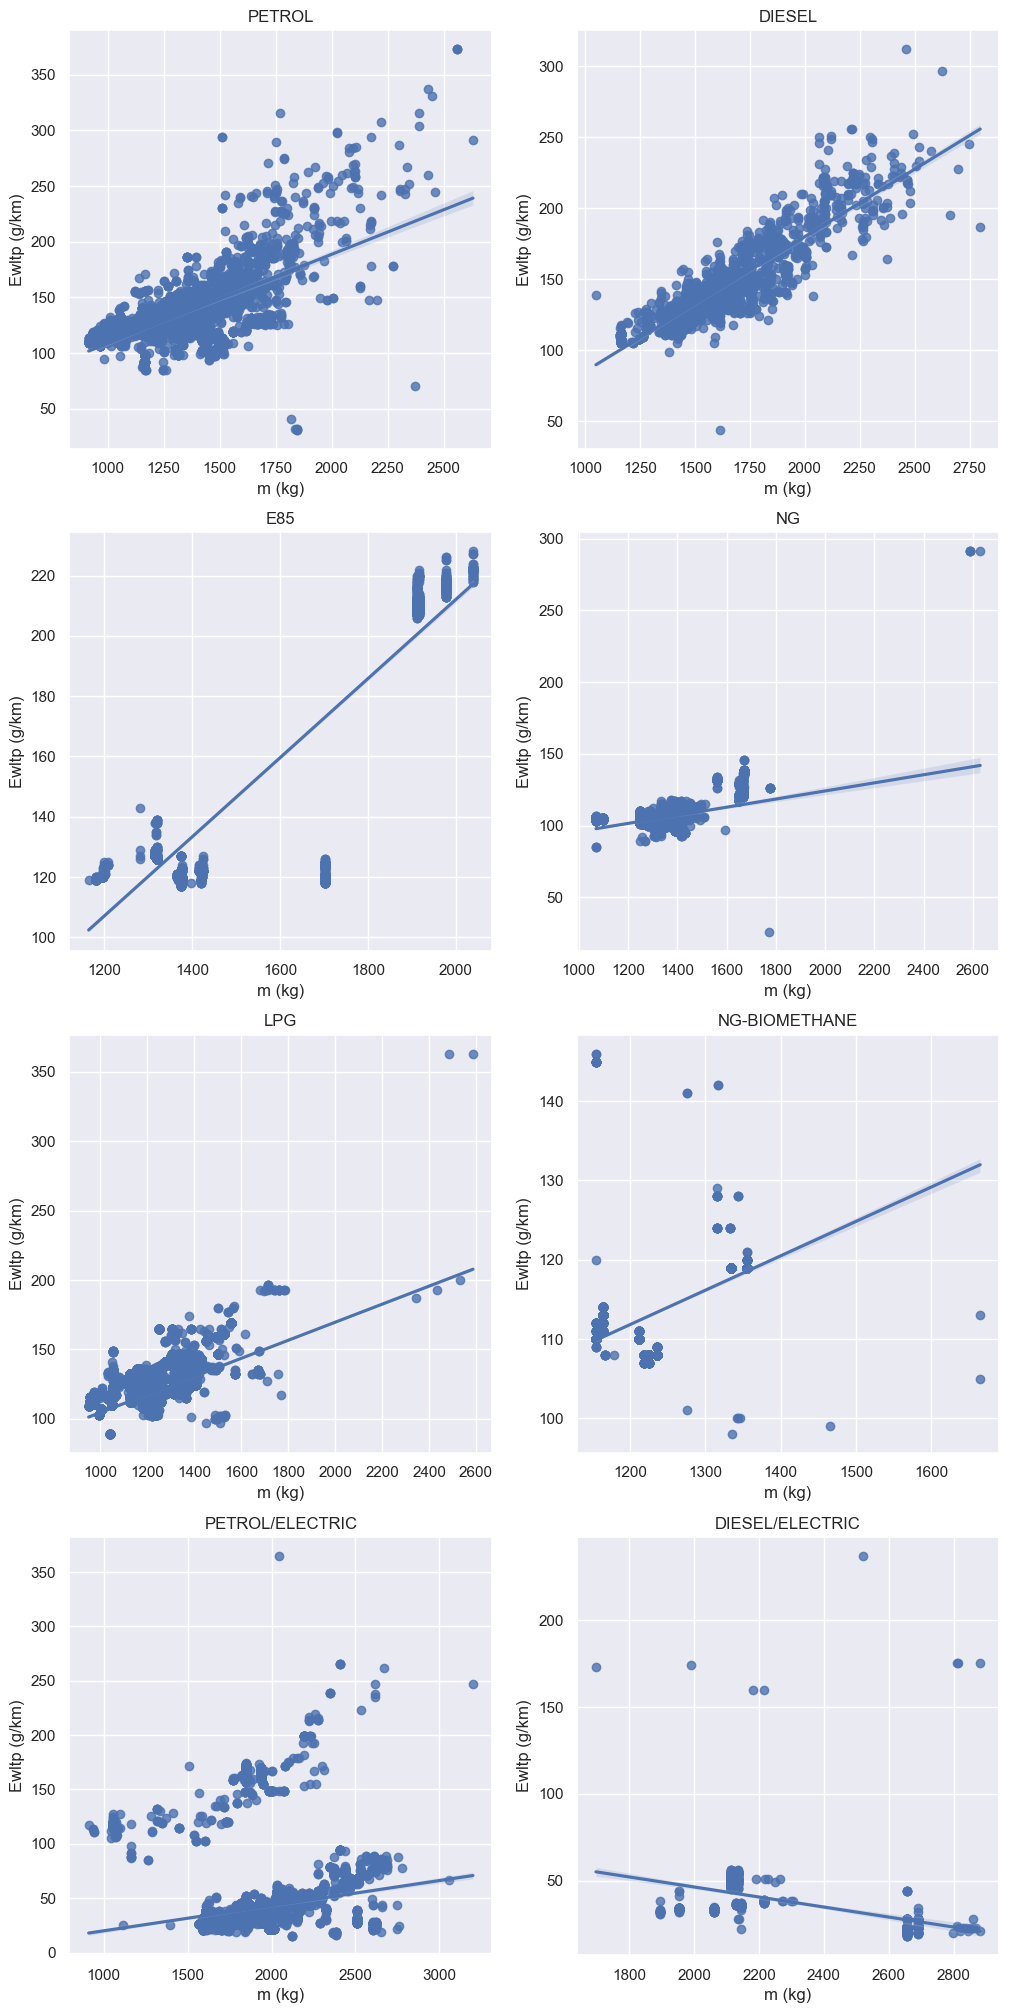

In [665]:
sns.set(rc = {'figure.figsize':(12,25)})

fig, axes = plt.subplots(4, 2)

for f, ax in zip(ft_list, axes.ravel()):

    dt = sampled_data_emm[sampled_data_emm["Ft"] == f]
    sns.regplot(data=dt, x='m (kg)', y='Ewltp (g/km)', ax=ax).set_title(f)

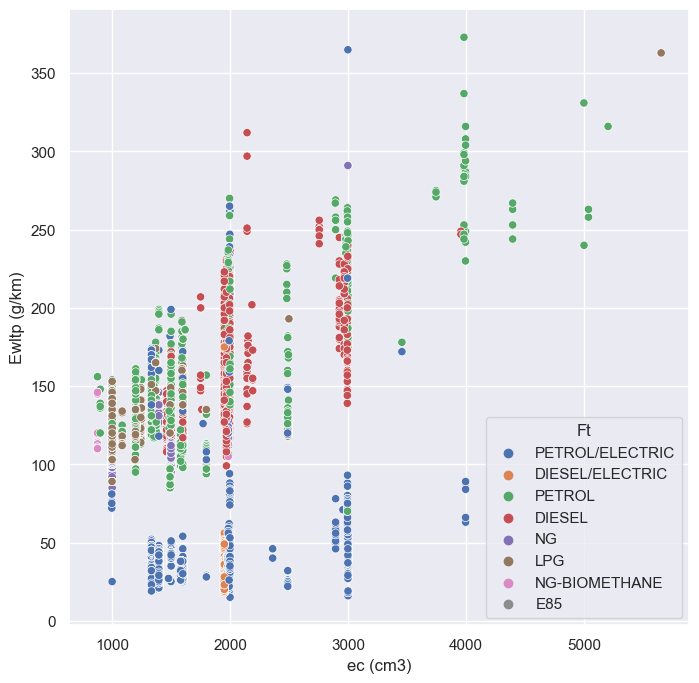

In [672]:
ft_list = ['PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE', 'PETROL/ELECTRIC','DIESEL/ELECTRIC']

marker = ['o', 'x', '^', 'v', '+', '*', '8', 's', 'p', 'D', 'V','X']
markers = [marker[i] for i in range(len(ft_list))]

plt.figure(figsize=(8,8))
sns.scatterplot(x='ec (cm3)',
            y='Ewltp (g/km)', 
            data=sampled_data_emm,
            hue='Ft',
            #style='Ft',\
            palette="deep"
            );

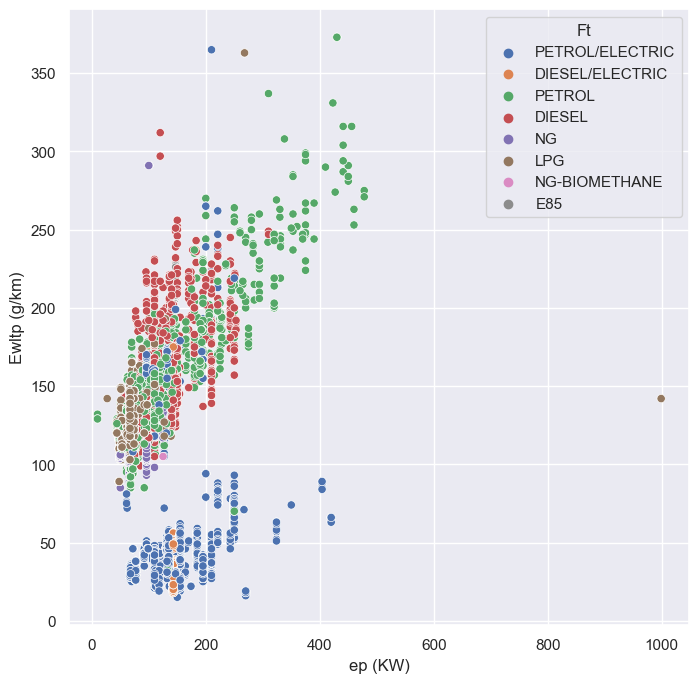

In [670]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='ep (KW)',
            y='Ewltp (g/km)', 
            data=sampled_data_emm,
            hue='Ft',
            );

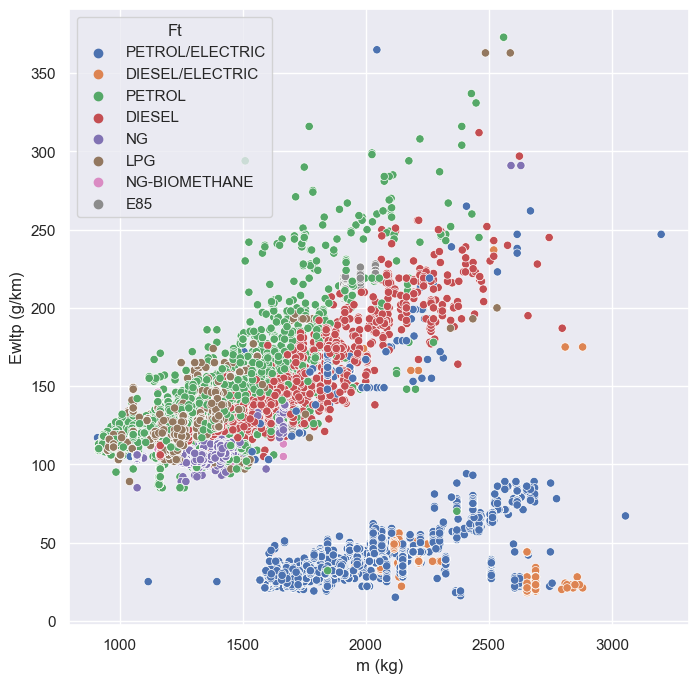

In [669]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='m (kg)',
            y='Ewltp (g/km)', 
            data=sampled_data_emm,
            hue='Ft',
            );

In [ ]:
from pyspark.sql import Row ,functions as f


#Q2. Compute average emission by manufacture  based on Ewltp (g/km)
mk_emission = veh_data.groupBy("Mk").agg(f.avg("Ewltp (g/km)").alias("Avg_emission"))
mk_emission = mk_emission.orderBy(mk_emission.Avg_emission.desc())
mk_emission = mk_emission.toPandas()


In [ ]:
# For each country compute the % of low ('PETROL/ELECTRIC','DIESEL/ELECTRIC', 'ELECTRIC', 'HYDROGEN') and high ('PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE') emission vehicles .  

ft_high_emm = ['PETROL', 'DIESEL', 'E85', 'NG', 'LPG', 'NG-BIOMETHANE']
ft_low_emm = [ 'PETROL/ELECTRIC','DIESEL/ELECTRIC', 'ELECTRIC', 'HYDROGEN']


df_emm = veh_data.withColumn(
    'emm_mode',
    f.when((f.col("Ft").isin(ft_high_emm)) , 'high')
    .otherwise('low')
)


grouped_df = df_emm.groupBy("Country", "emm_mode").agg(count("*").alias("count"))

grouped_df = grouped_df.orderBy(grouped_df.Country.asc())

grouped_df = grouped_df.toPandas()

grouped_df = grouped_df.sort_values(by=['Country', 'emm_mode'])


In [760]:
#ùpdate % values
for c in grouped_df['Country'].unique():
    #filter records
    recs = grouped_df[grouped_df['Country']==c]
    #total
    grp_tot = grouped_df[grouped_df['Country']==c]['count'].sum()
    #percentage
    perc = np.array(grouped_df[grouped_df['Country']==c]['count']/grp_tot)
    #update records
    grouped_df.loc[( (grouped_df['Country']==c) & (grouped_df['emm_mode']=='high')), 'perc']  = perc[0]
    grouped_df.loc[( (grouped_df['Country']==c) & (grouped_df['emm_mode']=='low')), 'perc']  = perc[1]

In [764]:
grouped_df = grouped_df.replace({"Country": full_country_name2})


Text(0, 0.5, 'Registration %')

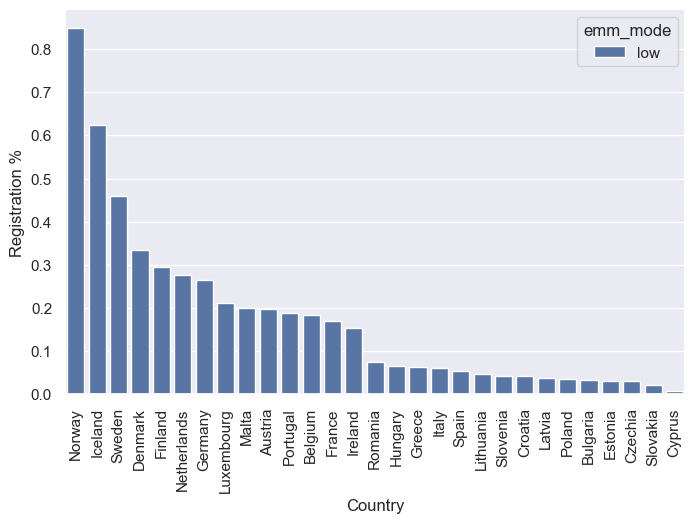

In [779]:
plt.figure(figsize=(8,5))

sns.barplot(data=grouped_df[grouped_df['emm_mode']=='low'].sort_values(by='perc', ascending=False), x='Country',y='perc', hue='emm_mode')
a=plt.xticks(rotation=90)
plt.ylabel("Registration %")


In [780]:
grouped_df[grouped_df['emm_mode']=='low'].sort_values(by='perc', ascending=False)

,Country,emm_mode,count,perc
44,Norway,low,132318,0.849352
31,Iceland,low,7289,0.624005
52,Sweden,low,111776,0.460336
12,Denmark,low,58502,0.334638
19,Finland,low,25634,0.294322
42,Netherlands,low,82027,0.277453
10,Germany,low,650406,0.265307
36,Luxembourg,low,8245,0.212030
40,Malta,low,969,0.200414
1,Austria,low,46440,0.197348


In [ ]:
grouped_df = df_emm.groupBy("Country", "emm_mode").agg(count("*").alias("count"))


In [800]:
#veh_data.filter(veh_data.Ft == "ELECTRIC").show()